NOTE: This notebook uses a JSON dictionary created by the `ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ADC_Saturation_Noisy_Chip_Time_Exploration.py` script. As this notebook comprises of preliminary/diagnostic studies, the code may not be fully optimized. The code will be optimized in terms of runtime and organization as time permits. Please contact Elise Hinkle (ehinkle@uchicago.edu) with any questions, comments, or concerns. Also, all JSON dictionary file locations are likely outdated and should be changed based on where the user has chosen to store the relevant dictionary(ies).

In [1]:
# Import relevant packages/libraries
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import tzinfo, timezone
import h5py
import argparse
from datetime import datetime
import glob
import json
import cmasher as cmr
import math
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import sys
import os
import pytz
import sys
sys.path.append('/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/')
from lar2x2_evd import *
from collections import Counter

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Hello


In [2]:
# Open noisy chip dictionary (need to change file location and noisy chip title for each chip)
noisy_chip_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ehinkle_personal_dicts_plots/noisy_chip_dicts/noisy_chip_6_7_99_dict.json'
noisy_chip_open = open(noisy_chip_file)
noisy_chip_dict = json.load(noisy_chip_open)
noisy_chip = '6/7/99'

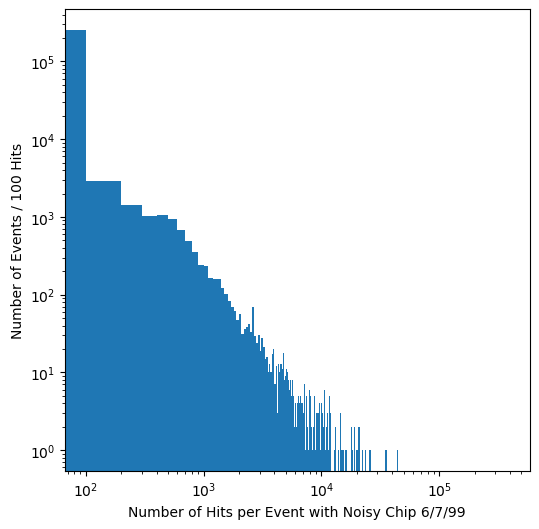

In [3]:
# Plot Number of Hits per Event for events recording packets on this "noisy chip"
fig, axs = plt.subplots(1,1, figsize=(6,6))
nhits_per_event = np.array([noisy_chip_dict[k]['nhits'] for k in noisy_chip_dict.keys()])
max_nhits = math.ceil(max(nhits_per_event)/100)*100
min_nhits = math.floor(min(nhits_per_event)/100)*100
axs.hist(nhits_per_event, bins=int((max_nhits-min_nhits)/100), range=(min_nhits, max_nhits))
axs.set_xlabel('Number of Hits per Event with Noisy Chip '+noisy_chip)
axs.set_ylabel('Number of Events / 100 Hits')
axs.set_yscale('log')
axs.set_xscale('log')

In [4]:
# Look at Timestamps of events receiving packets from noisy chip
# Timestamps are converted from string to seconds (unix timestamps)
# Some initial inquiry into the "first" event receiving a packet from this chip
timestamps_str = np.array([noisy_chip_dict[k]['timestamp'] for k in noisy_chip_dict.keys()])
timestamps = np.zeros(len(timestamps_str))
print(timestamps_str[:10])
tz=pytz.utc
for t in range(len(timestamps_str)):
    ti = datetime.strptime(timestamps_str[t],'%Y-%m-%d %H:%M:%S')
    ti = tz.localize(ti)
    #print("Timestamp as datetime object:", ti)
    timestamp = ti.timestamp()
    #print("Timestamp:", timestamp)
    timestamps[t] = timestamp
file_keys = np.array([k for k in noisy_chip_dict.keys()])
print("First timestamp:", min(timestamps))
idx_min_tstamp = np.argmin(np.array(timestamps))
print(idx_min_tstamp)
print("Key of first file:", file_keys[idx_min_tstamp])
print("Max timestamp:", max(timestamps))
print(timestamps[:10])

['2024-07-10 06:37:18' '2024-07-10 06:37:19' '2024-07-10 06:37:26'
 '2024-07-10 06:37:27' '2024-07-10 06:37:31' '2024-07-10 06:37:36'
 '2024-07-10 06:37:39' '2024-07-10 06:37:40' '2024-07-10 06:37:41'
 '2024-07-10 06:37:50']
First timestamp: 1720463873.0
30293
Key of first file: /global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050015-2024_07_08_13_37_49_CDT.FLOW.hdf5-45
Max timestamp: 1720784087.0
[1.72059344e+09 1.72059344e+09 1.72059345e+09 1.72059345e+09
 1.72059345e+09 1.72059346e+09 1.72059346e+09 1.72059346e+09
 1.72059346e+09 1.72059347e+09]


Finished plotting number of noisy chip packets.
Finished plotting average dataword in noisy chip packets.
Finished plotting number of channels from noisy chip packets.


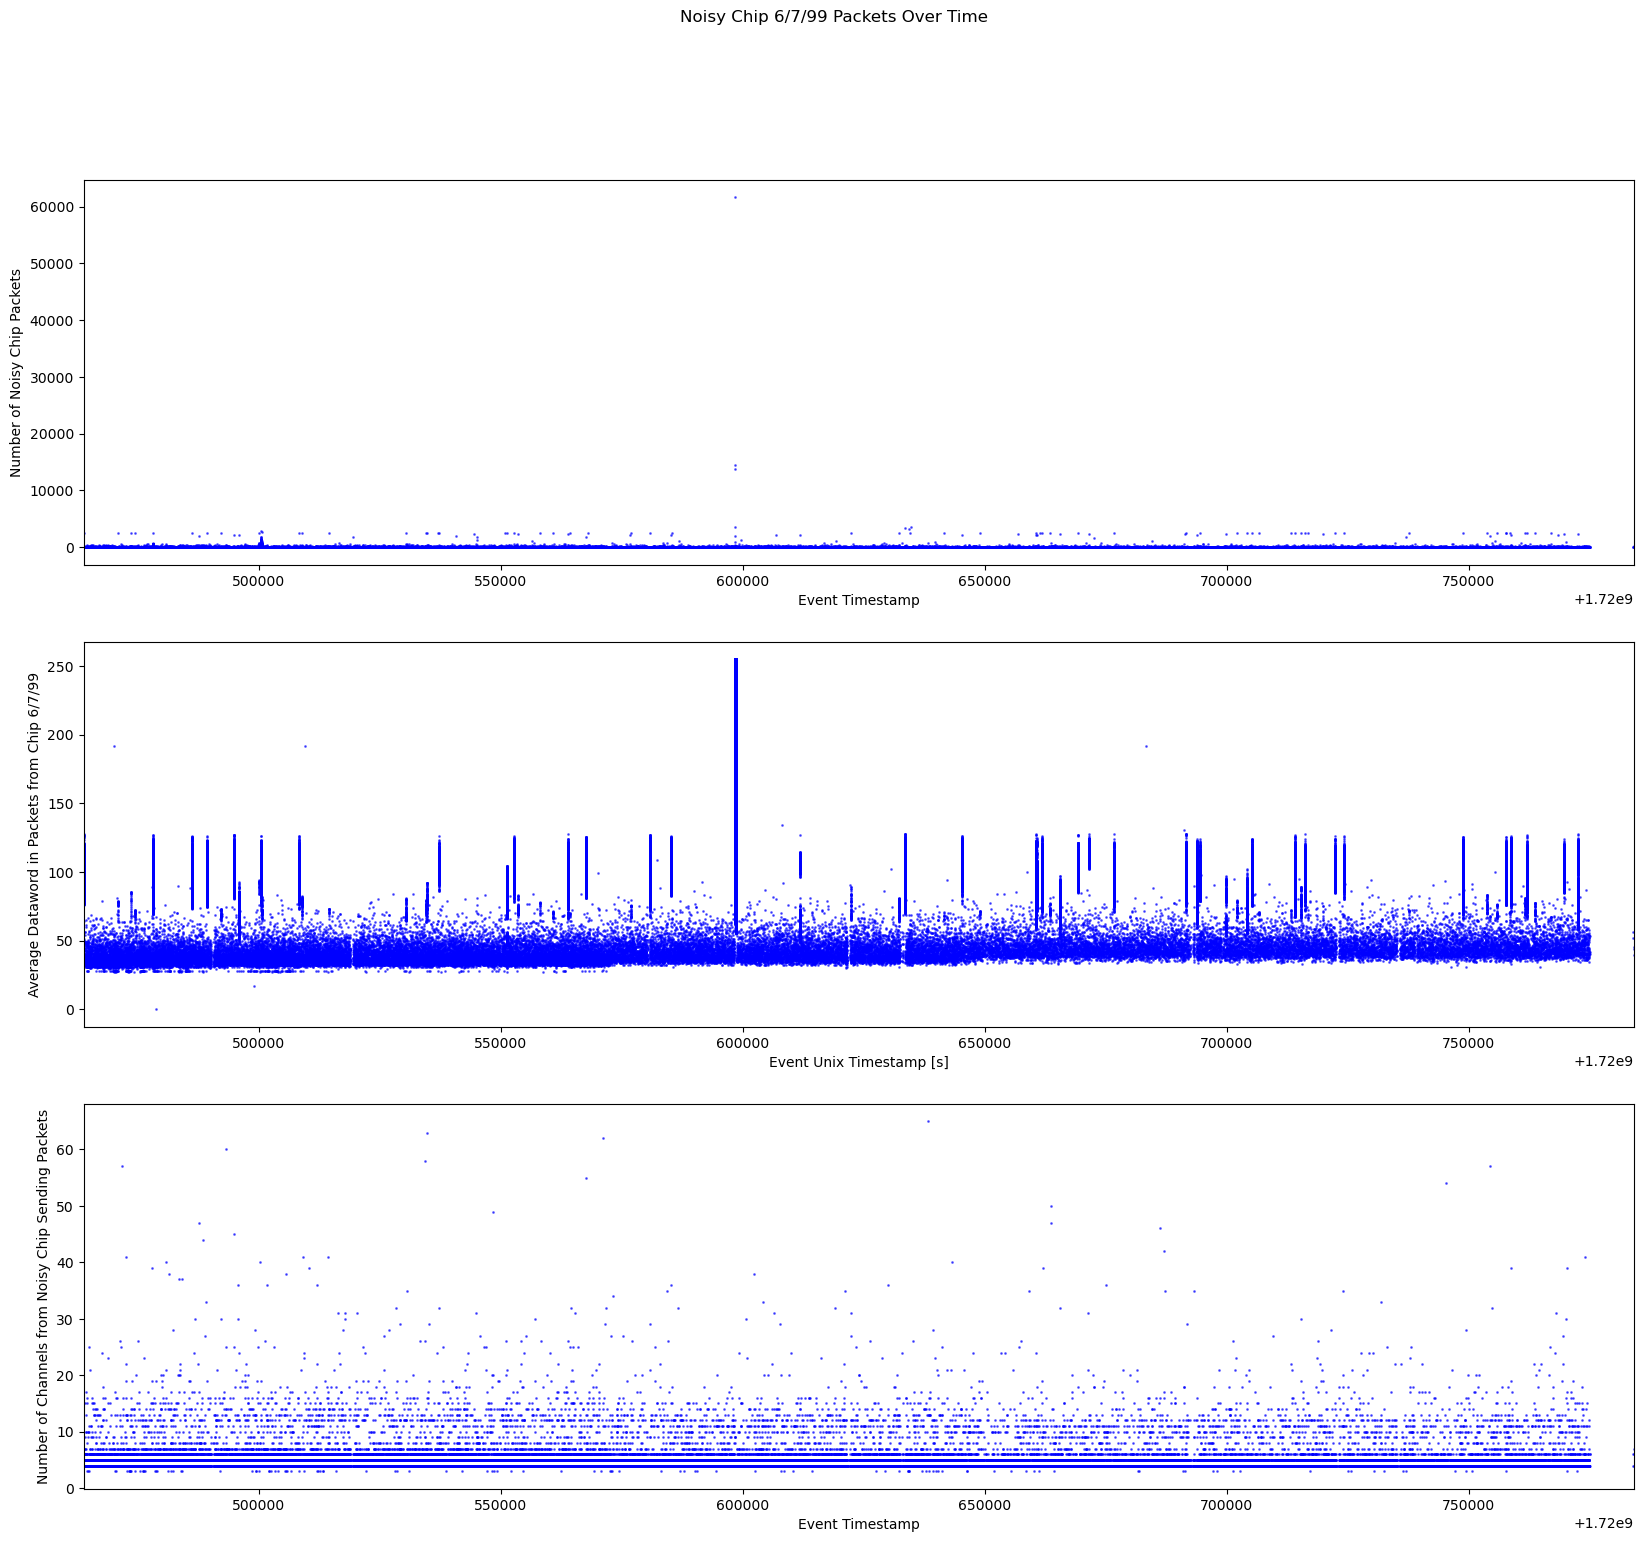

In [5]:
# This cell produces a series of plots showing the number of noisy chip packets, average dataword in packets, and number of channels sending packets from the chip over time 
# In each plot, one point = one event with a packet from the noisy chip. As the timestamps used are unix timestamps and non-beam events may occur on the sub-second
# timescale, there may be multiple events with the same timestamp.

# Look at number of noisy chip packets
num_noisy_chip_packets = np.array([noisy_chip_dict[k]['num_noisy_chip_packets'] for k in noisy_chip_dict.keys()])
average_dataword_noisy_chip_packet = np.array([np.mean(np.array(noisy_chip_dict[k]['dataword'])) for k in noisy_chip_dict.keys()])
num_channels = np.array([len(np.unique(np.array(noisy_chip_dict[k]['channels_impacted']))) for k in noisy_chip_dict.keys()])

# Look at number of noisy chip packets and average datawords and number of channels over time
fig, axs = plt.subplots(3,1, figsize=(20,17))
fig.suptitle('Noisy Chip '+noisy_chip+' Packets Over Time')
min_x = min(timestamps)
max_x = max(timestamps)
axs[0].scatter(timestamps, num_noisy_chip_packets, color='b', marker='o', s=1, alpha=0.55)
axs[0].set_xlabel('Event Timestamp')
axs[0].set_ylabel('Number of Noisy Chip Packets')
#axs[0].set_xticklabels([]) 
axs[0].set_xlim(min_x, max_x)

print("Finished plotting number of noisy chip packets.")

axs[1].scatter(timestamps, average_dataword_noisy_chip_packet, color='b', marker='o', s=1, alpha=0.55)
axs[1].set_xlabel('Event Unix Timestamp [s]')
axs[1].set_ylabel('Average Dataword in Packets from Chip '+noisy_chip)
#axs[1].set_xticklabels([]) 
axs[1].set_xlim(min_x, max_x)

print("Finished plotting average dataword in noisy chip packets.")

axs[2].scatter(timestamps, num_channels, color='b', marker='o', s=1, alpha=0.55)
axs[2].set_xlabel('Event Timestamp')
axs[2].set_ylabel('Number of Channels from Noisy Chip Sending Packets')
#axs[2].set_xticklabels([]) 
axs[2].set_xlim(min_x, max_x)

print("Finished plotting number of channels from noisy chip packets.")


First timestamp: 1720537322.0
First timestamp: 1720537322.0
Last timestamp: 1720537326.0
Next event: ['/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5-5570'
 '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5-5571'
 '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5-5572'
 '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5-5573'
 '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5-5574'
 '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_C

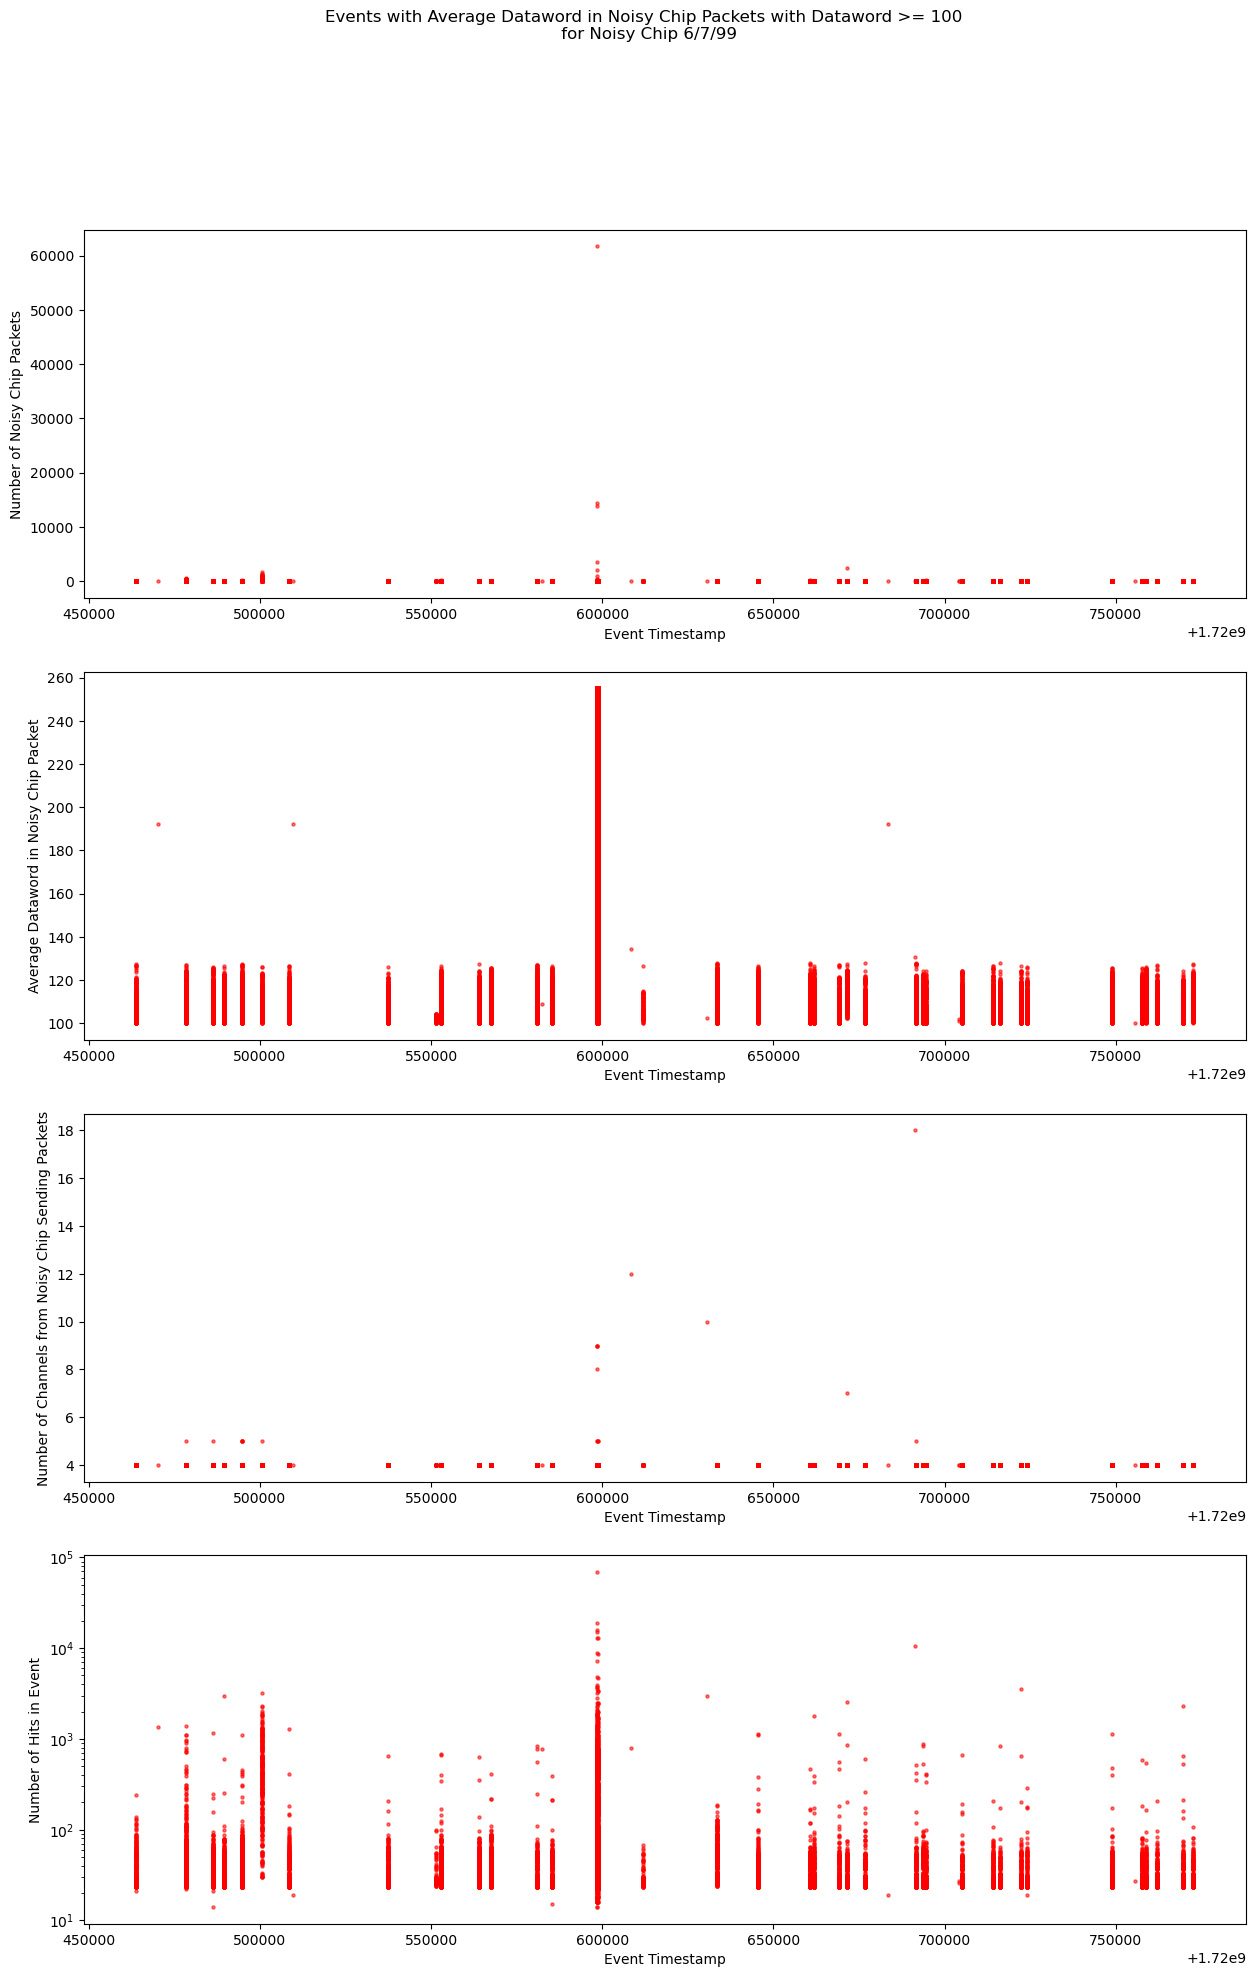

In [6]:
# This cell produces a series of plots showing the number of noisy chip packets, average dataword in packets, number of cumber of channels sending packets from the chip, 
# and the number of hits total in the event over time. These plots are for events with an average dataword in the noisy chip packets >= 200 
# In each plot, one point = one event with a packet from the noisy chip. As the timestamps used are unix timestamps and non-beam events may occur on the sub-second
# timescale, there may be multiple events with the same timestamp. For these plots, only 

# Look at high average dataword events
high_avg_dataword_mask = average_dataword_noisy_chip_packet >= 100
high_avg_dataword_timestamps = timestamps[high_avg_dataword_mask]
high_avg_dataword_num_noisy_chip_packets = num_noisy_chip_packets[high_avg_dataword_mask]
high_avg_dataword_num_channels = num_channels[high_avg_dataword_mask]
high_avg_dataword_nhits = nhits_per_event[high_avg_dataword_mask]
high_avg_dataword_avg_dataword = average_dataword_noisy_chip_packet[high_avg_dataword_mask]
high_avg_dataword_files = file_keys[high_avg_dataword_mask]

fig, axs = plt.subplots(4,1, figsize=(15,22))

axs[0].scatter(high_avg_dataword_timestamps, high_avg_dataword_num_noisy_chip_packets, color='r', marker='o', s=5, alpha=0.55)
axs[0].set_xlabel('Event Timestamp')
axs[0].set_ylabel('Number of Noisy Chip Packets')
#axs[0].set_xticklabels([])
#axs[0].set_xlim(min_x, max_x)

axs[1].scatter(high_avg_dataword_timestamps, high_avg_dataword_avg_dataword, color='r', marker='o', s=5, alpha=0.55)
axs[1].set_xlabel('Event Timestamp')
axs[1].set_ylabel('Average Dataword in Noisy Chip Packet')
#axs[1].set_xticklabels([])
#axs[1].set_xlim(min_x, max_x)

axs[2].scatter(high_avg_dataword_timestamps, high_avg_dataword_num_channels, color='r', marker='o', s=5, alpha=0.55)
axs[2].set_xlabel('Event Timestamp')
axs[2].set_ylabel('Number of Channels from Noisy Chip Sending Packets')
#axs[2].set_xticklabels([])
#axs[2].set_xlim(min_x, max_x)

axs[3].scatter(high_avg_dataword_timestamps, high_avg_dataword_nhits, color='r', marker='o', s=5, alpha=0.55)
axs[3].set_xlabel('Event Timestamp')
axs[3].set_ylabel('Number of Hits in Event')
#axs[3].set_xticklabels([])
axs[3].set_yscale('log')
#axs[3].set_xlim(min_x, max_x)

fig.suptitle('Events with Average Dataword in Noisy Chip Packets with Dataword >= 100 \n for Noisy Chip '+noisy_chip)

# BELOW: Trying to figure out when the first "high dataword event" is and what the previous and next events are
# Print Key of first file with high dataword event
time_mask = high_avg_dataword_timestamps >= 1720530000
high_avg_dataword_timestamps = high_avg_dataword_timestamps[time_mask]
high_avg_dataword_files = high_avg_dataword_files[time_mask]
time_mask_low = high_avg_dataword_timestamps <= 1720550000
high_avg_dataword_timestamps = high_avg_dataword_timestamps[time_mask_low]
high_avg_dataword_files = high_avg_dataword_files[time_mask_low]
idx_min_tstamp = np.argmin(np.array(high_avg_dataword_timestamps))
min_timestamp = min(high_avg_dataword_timestamps)
find_previous_event = np.where(timestamps == min_timestamp)
#print("Previous event:", file_keys[find_previous_event[0]-1])
#print("Previous event dataword:", average_dataword_noisy_chip_packet[find_previous_event[0]-1])
#print("Previous event timestamp:", timestamps[find_previous_event[0]-1][0])
print("First timestamp:", high_avg_dataword_timestamps[idx_min_tstamp])
#print("First timestamp:", datetime.utcfromtimestamp(
#                high_avg_dataword_timestamps[idx_min_tstamp]).strftime('%Y-%m-%d %H:%M:%S'))
print("First timestamp:", min(high_avg_dataword_timestamps))
print("Last timestamp:", max(high_avg_dataword_timestamps))
last_timestamp_idx = np.argmax(np.array(high_avg_dataword_timestamps))
find_next_event = np.where(timestamps == max(high_avg_dataword_timestamps))
print("Next event:", file_keys[find_next_event[0]+1])
print("Last event: ", high_avg_dataword_files[last_timestamp_idx])
#print("First timestamp:", datetime.fromtimestamp(min(high_avg_dataword_timestamps)))
print("Key of first file:", high_avg_dataword_files[idx_min_tstamp])
print("Timestamp of first file:", high_avg_dataword_timestamps[idx_min_tstamp])
print("Timestamp of first file from dictionary:", noisy_chip_dict[high_avg_dataword_files[idx_min_tstamp]]['timestamp'])

[1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.72053732e+09 1.72053732e+09 1.72053732e+09
 1.72053732e+09 1.720537

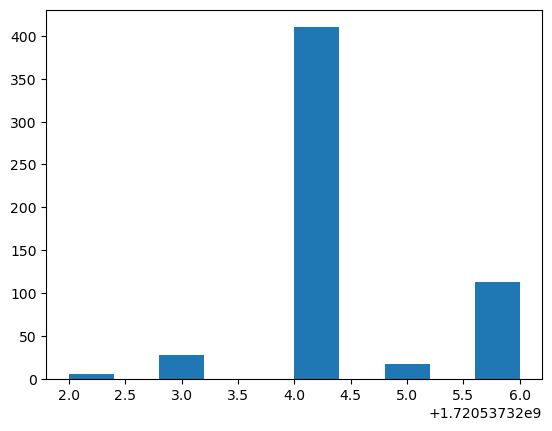

In [ ]:
# Look at distribution in time of high average dataword events over time in a lower resolution histogram
plt.hist(high_avg_dataword_timestamps, bins=10)
print(high_avg_dataword_timestamps)

<KeysViewHDF5 ['calib_final_hits', 'calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'raw_events', 'raw_hits']>


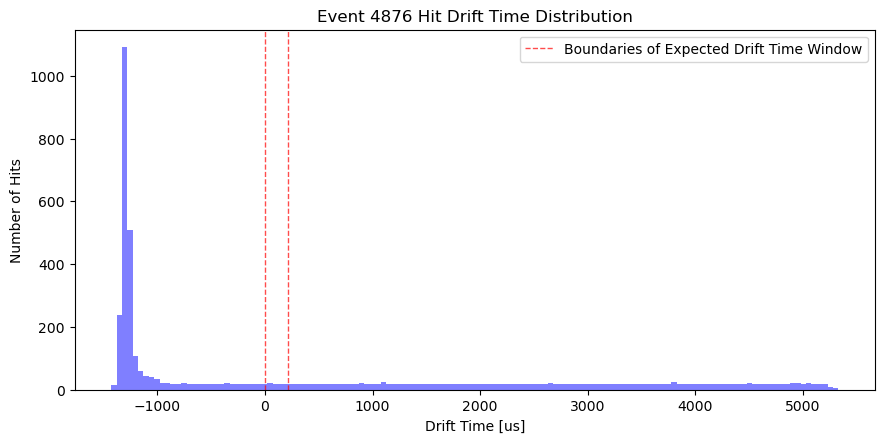

In [32]:
# Look into particular event where HPT activity may have originated on 6/7/99 chip (in one of the HPT instances)
file = '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v5/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_09_55_36_CDT.FLOW.hdf5'
ev_id = 4876

with h5py.File(file, 'r') as f:
    
    print(f['charge'].keys())
    events = f['charge/events/data']
    hits_full = f['charge/calib_prompt_hits/data']
    hits_ref = f['charge/events/ref/charge/calib_prompt_hits/ref']
    hits_region = f['charge/events/ref/charge/calib_prompt_hits/ref_region']
    packets_full = f['charge/packets/data']
    packets_ref = f['charge/calib_prompt_hits/ref/charge/packets/ref']

    event_mask = events['id'] == ev_id
    event = events[event_mask]
    hit_ref = hits_ref[hits_region[ev_id,'start']:hits_region[ev_id,'stop']]
    hit_ref = np.sort(hit_ref[hit_ref[:,0] == ev_id, 1])
    hits = hits_full[hit_ref]
    packet_ref = packets_ref[hit_ref]
    packet_ref = np.sort(packet_ref[:, 1])
    packets_event = packets_full[packet_ref]

    max_drift_time = math.ceil(max(hits['t_drift']/10)/10)*10
    min_drift_time = math.floor(min(hits['t_drift']/10)/10)*10
    dt_bins=np.linspace(min_drift_time, max_drift_time, int((max_drift_time-min_drift_time)/50)+1)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0.1, 0.25, 0.8, 0.6])
    ax.hist(hits['t_drift']/10, histtype='stepfilled', color='b', alpha=0.5, bins=dt_bins)
    ax.set_xlabel('Drift Time [us]')
    ax.set_ylabel('Number of Hits')
    ax.set_title('Event '+str(ev_id)+' Hit Drift Time Distribution') 
    ax.axvline(0, color='r', linestyle='--', alpha=0.7, linewidth=1, label='Boundaries of Expected Drift Time Window')
    ax.axvline(210, color='r', linestyle='--', alpha=0.7, linewidth=1)
    plt.legend()
    #ax.set_yscale('log')